In [48]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder, , StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
import numpy as np
# from sklearn.ensemble import RandomForestRegressor 
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import KFold

In [2]:
import warnings
pd.set_option('mode.chained_assignment', None)  # SettingWithCopyWarning 경고 무시
warnings.simplefilter(action='ignore', category=[FutureWarning, UserWarning, ]) # FutureWarning 제거

In [17]:
# Load raw dataset
r_train = pd.read_csv("./dataset/raw/train.csv")
r_test = pd.read_csv("./dataset/raw/test.csv")
print("==== Raw train.csv ====")
r_train[:3]

==== Raw train.csv ====


,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950
1,2018-01-02,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136
2,2018-01-03,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156


In [4]:
print("==== Raw test.csv ====")
r_test[:3]

==== Raw test.csv ====


,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1
1,2021-01-02,NaN,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,5.4
2,2021-01-03,NaN,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,4.5


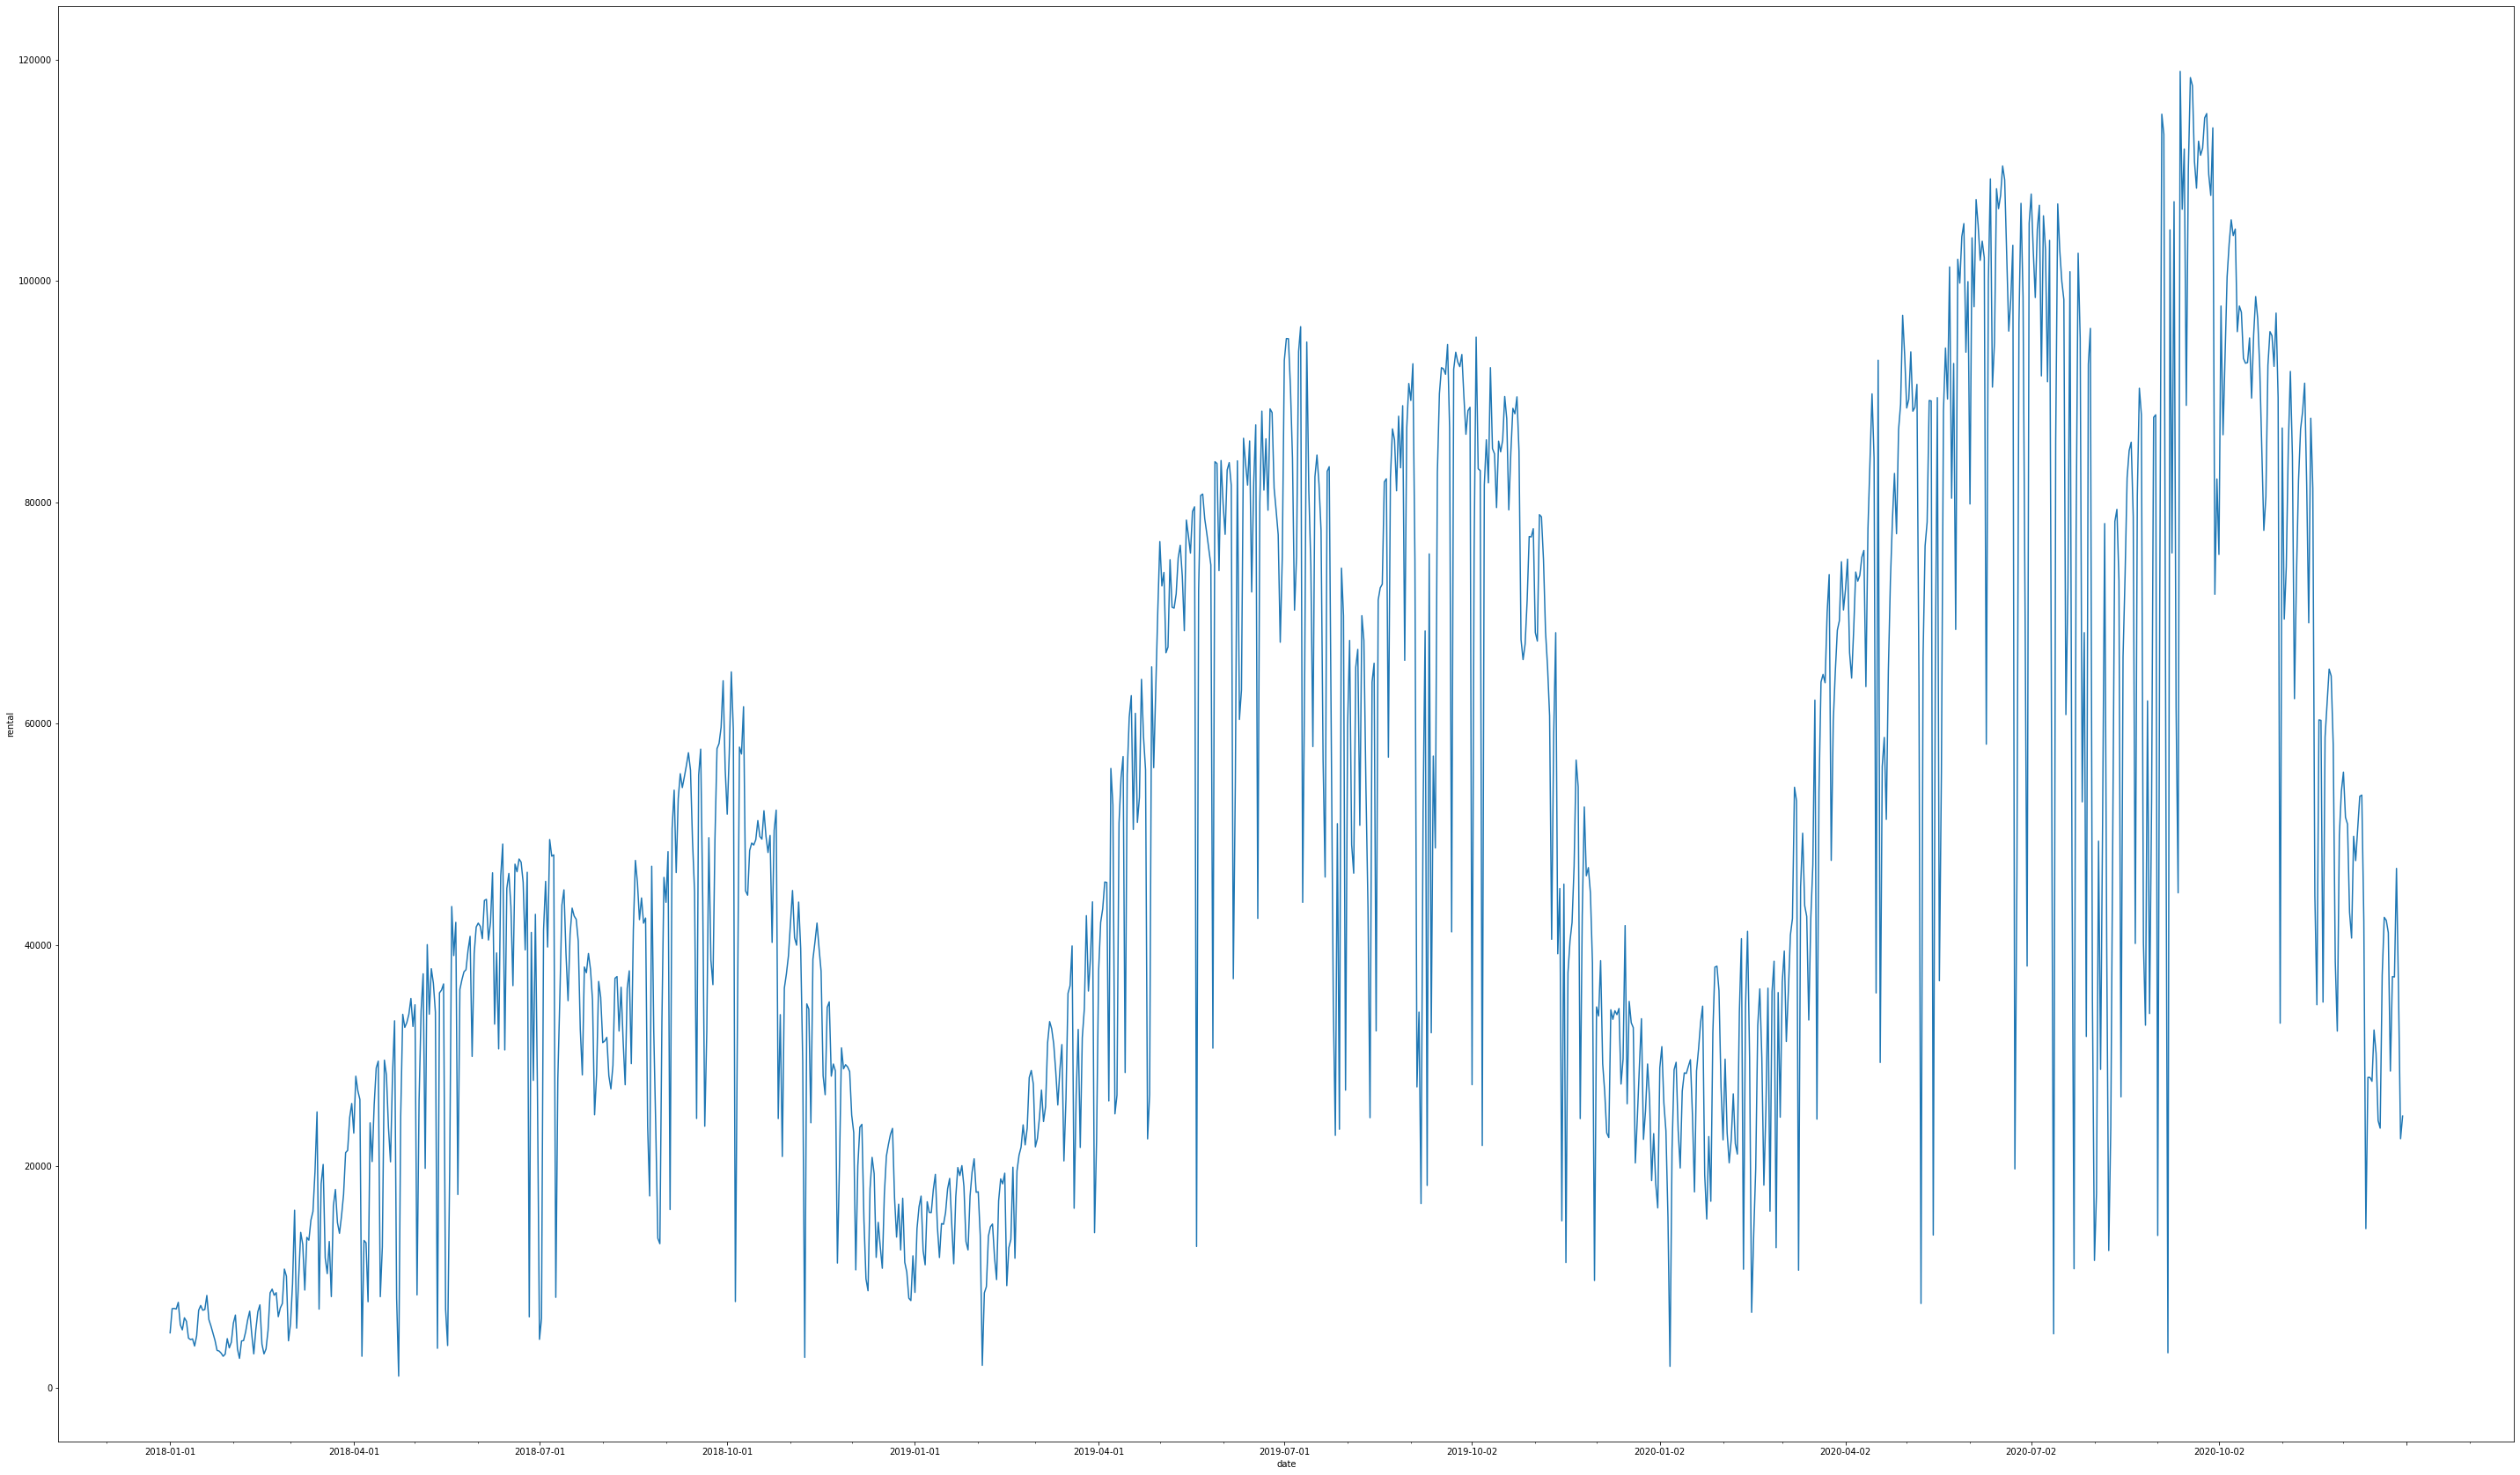

In [5]:
# 시간에 따른 데이터 양상
from matplotlib.dates import MonthLocator, DateFormatter
%matplotlib inline
# x:date, y:rent
xs = r_train['date'].to_list()
ys = r_train['rental'].to_list()


fig = plt.figure(figsize=(50, 30))
ax = fig.add_subplot()
plt.xlabel("date")
plt.ylabel("rental")
# ax = fig.add_subplot()
ax.plot(xs, ys)
# ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d')) # 날짜 표시 형식
ax.xaxis.set_major_locator(MonthLocator(interval=3))     # 3개월마다 눈금 표시
ax.xaxis.set_minor_locator(MonthLocator(interval=1)) ## 1개월마다 서브 눈금을 표시한다.

In [18]:
# date 분리 in train
train = r_train
train['date'] = pd.to_datetime(train['date'])
train['year'] = r_train['date'].dt.year
train['month'] = r_train['date'].dt.month
train['day'] = r_train['date'].dt.day
train = train.drop(['date'], axis=1)

In [19]:
# date 분리 in test
test = r_test
test['date'] = pd.to_datetime(test['date'])
test['year'] = r_test['date'].dt.year
test['month'] = r_test['date'].dt.month
test['day'] = r_test['date'].dt.day
test = test.drop(['date'], axis=1)

In [18]:
! pip install seaborn
import seaborn as sns
# raw data heatmap
sns.heatmap(train.corr(), cmap='Blues')

TypeError: issubclass() arg 2 must be a class or tuple of classes

In [19]:
train[:5]

,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,year,month,day
0,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950,2018,1,1
1,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136,2018,1,2
2,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156,2018,1,3
3,NaN,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102,2018,1,4
4,NaN,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705,2018,1,5


In [22]:
# sunshine sum 결측치 처리 in train
nan_idx_ss = train['sunshine_sum'][train['sunshine_sum'].isnull()].index
print("sunshine sum nan indice: ", nan_idx_ss)

tgt_ss = train['sunshine_sum'].dropna().values.reshape(-1, 1)
x_sr = train['sunshine_rate'].drop(nan_idx_ss).values.reshape(-1, 1)

from sklearn.linear_model import LinearRegression

# LR 학습
lreg_ss = LinearRegression()
lreg_ss.fit(x_sr, tgt_ss)

pred_ss = lreg_ss.predict(train['sunshine_rate'].loc[nan_idx_ss].values.reshape(-1, 1))
pred_ss = list(pred_ss)
print(pred_ss)

# Test는 우선 생략
# t_nan_list_ss = test_df['sunshine_sum'][test_df['sunshine_sum'].isnull()].index
# print(t_nan_list_ss)

sunshine sum nan indice:  Int64Index([17, 25, 45, 187, 604], dtype='int64')
[array([0.18883871]), array([0.18883871]), array([0.18883871]), array([0.18883871]), array([0.18883871])]


In [23]:
# PM10, PM2.5, sunshine_sum 결측치 채우기 in train

train["PM10"] = train["PM10"].fillna(train["PM10"].mean())
train["PM2.5"] = train["PM2.5"].fillna(train["PM2.5"].mean())

for nan, pred in zip(nan_idx_ss, pred_ss):
    train["sunshine_sum"].iloc[nan] = pred

In [24]:
# precipitation(강수량) 결측치 채우기 in train
nan_idx_pp= train['precipitation'][train['precipitation'].isnull()].index
print(nan_idx_pp)

tgt_pp = train['precipitation'].dropna()
columns = ['sunshine_rate','sunshine_sum','month']
x_srss = train[columns].drop(nan_idx_pp)

# Scaling
scaler = MinMaxScaler()
scaler.fit(x_srss)
x_scaled = scaler.transform(x_srss)

# LR 학습
lreg_pp = LinearRegression()
lreg_pp.fit(x_scaled, tgt_pp)

x_nanpp = scaler.transform(train[columns].iloc[nan_idx_pp])
pred_pp = lreg_pp.predict(x_nanpp)
pred_pp = list(pred_pp)

for nan, pred in zip(nan_idx_pp, pred_pp):
    train["precipitation"].iloc[nan] = pred

# t_nan_list_pp = test_df['precipitation'][train_df['precipitation'].isnull()].index
# print(t_nan_list_pp)
# t_pp = test_df['precipitation'].dropna()
# t_srss = test_df[['sunshine_rate','sunshine_sum','month']].drop(t_nan_list_pp)

Int64Index([   0,    1,    2,    3,    4,    5,    6,   10,   13,   16,
            ...
            1078, 1079, 1082, 1083, 1084, 1085, 1087, 1088, 1089, 1093],
           dtype='int64', length=678)


In [25]:
# sunshine sum 결측치 처리 in test
nan_idx_ss = test['sunshine_sum'][test['sunshine_sum'].isnull()].index
print("sunshine sum nan indice: ", nan_idx_ss)

tgt_ss = test['sunshine_sum'].dropna().values.reshape(-1, 1)
x_sr = test['sunshine_rate'].drop(nan_idx_ss).values.reshape(-1, 1)

from sklearn.linear_model import LinearRegression

# LR 학습
lreg_ss = LinearRegression()
lreg_ss.fit(x_sr, tgt_ss)

pred_ss = lreg_ss.predict(test['sunshine_rate'].loc[nan_idx_ss].values.reshape(-1, 1))
pred_ss = list(pred_ss)
print(pred_ss)

sunshine sum nan indice:  Int64Index([6], dtype='int64')
[array([0.20006253])]


In [26]:
# PM10, PM2.5, sunshine_sum 결측치 채우기 in test
test["PM10"] = test["PM10"].fillna(test["PM10"].mean())
test["PM2.5"] = test["PM2.5"].fillna(test["PM2.5"].mean())

for nan, pred in zip(nan_idx_ss, pred_ss):
    test["sunshine_sum"].iloc[nan] = pred

In [27]:
# precipitation(강수량) 결측치 채우기 in test
nan_idx_pp= test['precipitation'][test['precipitation'].isnull()].index
print(nan_idx_pp)

tgt_pp = test['precipitation'].dropna()
columns = ['sunshine_rate','sunshine_sum','month']
x_srss = test[columns].drop(nan_idx_pp)

# Scaling
scaler = MinMaxScaler()
scaler.fit(x_srss)
x_scaled = scaler.transform(x_srss)

# LR 학습
lreg_pp = LinearRegression()
lreg_pp.fit(x_scaled, tgt_pp)

x_nanpp = scaler.transform(test[columns].iloc[nan_idx_pp])
pred_pp = lreg_pp.predict(x_nanpp)
pred_pp = list(pred_pp)

for nan, pred in zip(nan_idx_pp, pred_pp):
    test["precipitation"].iloc[nan] = pred

# t_nan_list_pp = test_df['precipitation'][train_df['precipitation'].isnull()].index
# print(t_nan_list_pp)
# t_pp = test_df['precipitation'].dropna()
# t_srss = test_df[['sunshine_rate','sunshine_sum','month']].drop(t_nan_list_pp)

Int64Index([  0,   1,   2,   6,   7,   8,   9,  10,  13,  15,
            ...
            345, 346, 350, 354, 355, 356, 358, 359, 361, 364],
           dtype='int64', length=205)


In [28]:
# train 결측치 전부 채움
train.isnull().sum()

precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
rental           0
year             0
month            0
day              0
dtype: int64

In [29]:
# test 결측치 전부 채움
train.isnull().sum()

precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
rental           0
year             0
month            0
day              0
dtype: int64

# 시각화

In [36]:
train.columns

Index(['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'rental', 'year', 'month', 'day'],
      dtype='object')

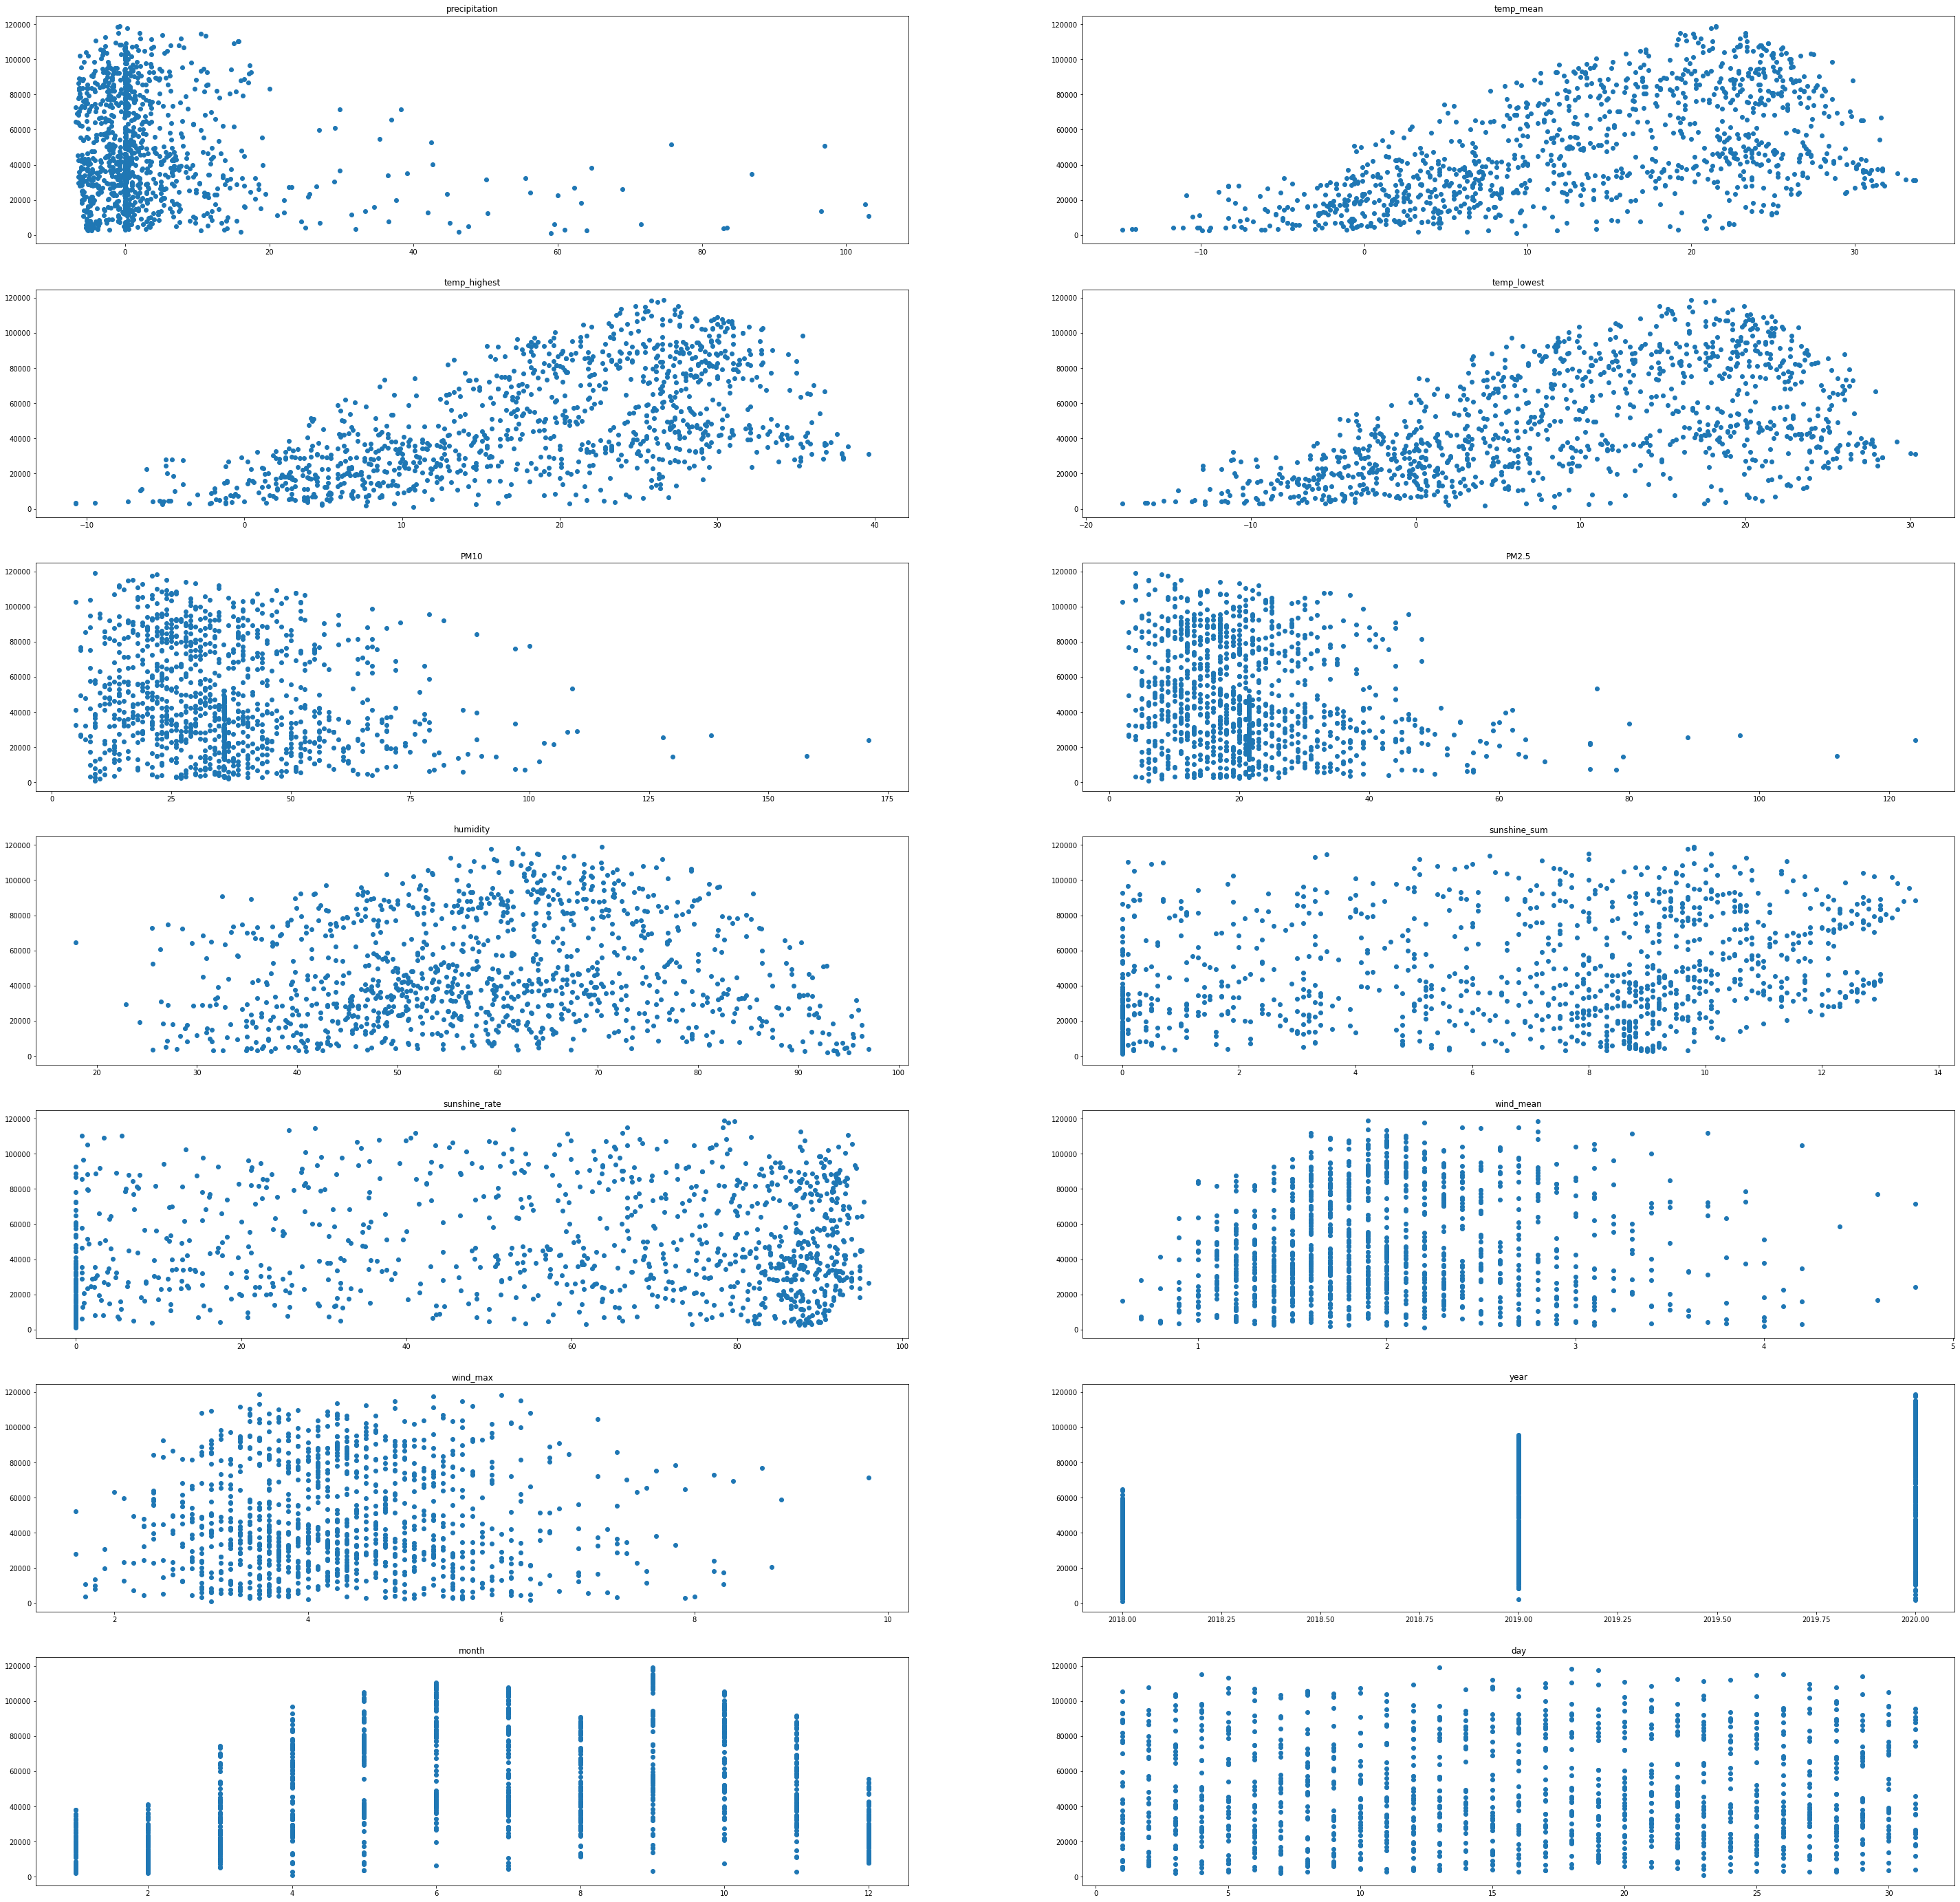

In [45]:
columns = ['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'year', 'month', 'day']

fig, ax = plt.subplots(7, 2, figsize=(50,50))
 
# scatter plot
for i, col in zip(range(14), columns):
    j = i%2
    i = int(i/2)
    ax[i][j].scatter(train[col], train['rental'])
    ax[i][j].set(title=col)

# 2018\~2019, 2019\~2020년도 각 월별 증가량 추이

In [25]:
train_2018 = train[train['year'] == 2018]
train_2019 = train[train['year'] == 2019]
train_2020 = train[train['year'] == 2020]
s2018 = {}
s2019 = {}
s2020 = {}

# 연도[월] = 해당연도 해당월 렌트량 합
for i in range(1, 13):
    s2018[i] = train_2018[train_2018['month'] == i]['rental'].values.sum()
    s2019[i] = train_2019[train_2019['month'] == i]['rental'].values.sum()
    s2020[i] = train_2020[train_2020['month'] == i]['rental'].values.sum()

In [26]:
# 월별 변화량
d1819 = {}
d1920 = {}
d1820 = {}

for i in range(1, 13):
    d1819[i] = (s2019[i] - s2018[i])/s2018[i]
    d1920[i] = (s2020[i] - s2019[i])/s2019[i]
    d1820[i] = (s2020[i] - s2018[i])/s2018[i]

In [27]:
from sklearn.linear_model import BayesianRidge
import numpy as np

# Bayesian Curve Fitting

In [50]:
test_label = pd.read_csv("./dataset/raw/test_label.csv")
test_label['rental'][:5]
# test_label['rental'].apply(pd.to_numeric)
# y_pred.dtype

0    22274
1    23631
2    21809
3    32957
4    29033
Name: rental, dtype: int64

In [51]:
# 데이터 처리
columns = ['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'month', 'day']
columns_year = ['precipitation', 'temp_mean', 'temp_highest', 'temp_lowest', 'PM10',
       'PM2.5', 'humidity', 'sunshine_sum', 'sunshine_rate', 'wind_mean',
       'wind_max', 'month', 'day', 'year']  # 'year' 추가


# 전체 데이터 (이거 사용해도 됨)
X = np.array(train[columns].values.tolist())    # year 없음
X_year = np.array(train[columns_year].values.tolist())    # year 있음
y = np.array(train['rental'].values.tolist())


X_test = np.array(test[columns].values.tolist())    # year 없음
X_test_year = np.array(test[columns_year].values.tolist())    # year 있음

y_test = np.array(test_label['rental'].values.tolist())

In [ ]:
# 모델 학습(Bayesian Curve Fitting)
n_order = 2
reg = BayesianRidge(tol=1e-6, fit_intercept=True, compute_score=True)
reg.fit(X_year, y)

In [48]:
# train 전체(X) 사용
tmp = reg.predict(X_year)
print(tmp.reshape(-1, 1).shape)
print(np.array(y).reshape(-1, 1).shape)

(1095, 1)
(1095, 1)


In [46]:
# x_train, x_test로 분할해서 사용
tmp = reg.predict(X_test)
print(tmp.reshape(-1, 1).shape)
print(np.array(y_test).reshape(-1, 1).shape)

ValueError: X has 13 features, but BayesianRidge is expecting 14 features as input.

In [7]:
import numpy as np

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [52]:
y = y.reshape(-1, 1)

# for x, y in zip(X_train, y_train):
#     pred = reg.predict(x.reshape(-1, 1))
# #     pred = pred.reshape(-1, 1)
# #     print(pred.shape, y.shape)
#     print(NMAE(y, pred))

pred = reg.predict(X_year)
y = y.reshape(-1)

NMAE(y, pred)     # year 있는게 더 낮은 loss. 정규화 없이 해서 그런듯

0.5045666118591284

# Polynomial Regression (다항회귀)
- sklearn Polynomial Features

## year 데이터 포함

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from preprocess import get_train_test
import pandas as pd

X, X_year, y, X_test, X_test_year, y_test = get_train_test()
submit_csv = pd.read_csv("./dataset/raw/sample_submission.csv")

In [61]:
X_year.shape

(1095, 14)

In [3]:
# poly 데이터 생성
poly_features = PolynomialFeatures(degree=2, include_bias=True) # 기본 다항식형태를 만들고
x_poly = poly_features.fit_transform(X_year)

In [4]:
# 학습
from sklearn.linear_model import LinearRegression
# model.coef_, model.intercept_
model = LinearRegression()
model.fit(x_poly, y) # 다항회귀 모델에 그렇게 변형한 데이터와 기존 y값을 넣고 학습시킨다.

LinearRegression()

In [5]:
y_pred = model.predict(x_poly)

In [8]:
# train
NMAE(y, y_pred)

0.24770129399148355

In [9]:
# test
x_test_poly = poly_features.transform(X_test_year)
y_test_pred = model.predict(x_test_poly)
NMAE(y_test, y_test_pred)

0.3404327835458352

In [12]:
submit_csv['rental'] = y_test_pred

In [17]:
submit_csv.to_csv("./dataset/submit_poly.csv", sep=',', na_rep="NaN", index=False)

In [71]:
x_poly.shape

(1095, 680)

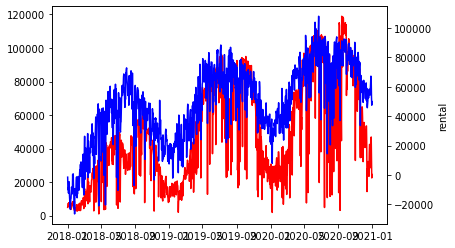

In [131]:
# 1차원 피팅 그래프 (파라미터 바꿔가면서 함)
fig, ax1 = plt.subplots()
ax1.plot(r_train['date'], y, color='red')

ax2 = ax1.twinx()
ax2.plot(r_train['date'], y_pred, color='blue')
plt.xlabel("date")
plt.ylabel("rental")

plt.show()

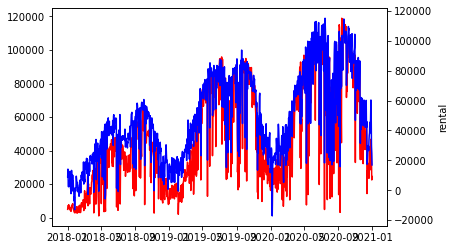

In [146]:
# 2차원 피팅 그래프 (파라미터 바꿔가면서 함)
fig, ax1 = plt.subplots()
ax1.plot(r_train['date'], y, color='red')

ax2 = ax1.twinx()
ax2.plot(r_train['date'], y_pred, color='blue')    # 파란색이 y_pred
plt.xlabel("date")
plt.ylabel("rental")

plt.show()

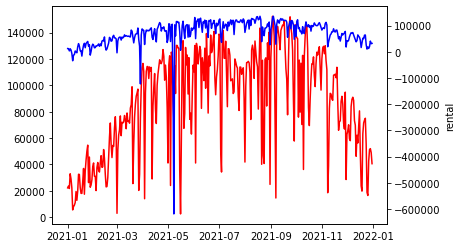

In [147]:
# 2차원 피팅 그래프 (파라미터 바꿔가면서 함)
fig, ax1 = plt.subplots()
ax1.plot(r_test['date'], y_test, color='red')

ax2 = ax1.twinx()
ax2.plot(r_test['date'], y_test_pred, color='blue')
plt.xlabel("date")
plt.ylabel("rental")

plt.show()

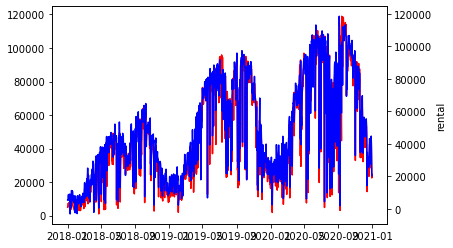

In [69]:
# 3차원 피팅 그래프
fig, ax1 = plt.subplots()
ax1.plot(r_train['date'], y, color='red')

ax2 = ax1.twinx()
ax2.plot(r_train['date'], y_pred, color='blue')
plt.xlabel("date")
plt.ylabel("rental")

plt.show()

In [140]:
# 4차원 피팅 그래프
fig = plt.figure() 
ax1 = plt.subplots()
ax1.plot(r_train['date'], y, color='red')

ax2 = ax1.twinx()
ax2.plot(r_train['date'], y_pred, color='blue')
plt.xlabel("date")
plt.ylabel("rental")


TypeError: subplots() takes from 0 to 2 positional arguments but 3 were given

In [69]:
r_train['date'][:5]

0   2018-01-01
1   2018-01-02
2   2018-01-03
3   2018-01-04
4   2018-01-05
Name: date, dtype: datetime64[ns]

## year 데이터 미포함

In [ ]:
poly_features = PolynomialFeatures(degree=1, include_bias=True) # 기본 다항식형태를 만들고
x_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(x_poly, y)

In [149]:
# train
y_pred = model.predict(x_poly)
print(NMAE(y, y_pred))

# test
x_test_poly = poly_features.transform(X_test)
y_test_pred = model.predict(x_test_poly)
print(NMAE(y_test, y_test_pred))

0.4773189617221077
0.5705795178442792


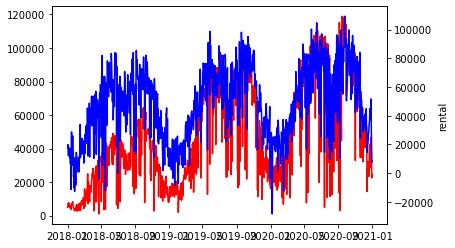

In [150]:
# 2차원 피팅 그래프 (파라미터 바꿔가면서 함)
fig, ax1 = plt.subplots()
ax1.plot(r_train['date'], y, color='red')

ax2 = ax1.twinx()
ax2.plot(r_train['date'], y_pred, color='blue')    # 파란색이 y_pred
plt.xlabel("date")
plt.ylabel("rental")

plt.show()

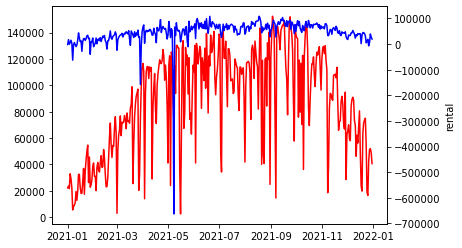

In [151]:
# 2차원 피팅 그래프 (파라미터 바꿔가면서 함) 오... 존나 절망적이다
fig, ax1 = plt.subplots()
ax1.plot(r_test['date'], y_test, color='red')

ax2 = ax1.twinx()
ax2.plot(r_test['date'], y_test_pred, color='blue')
plt.xlabel("date")
plt.ylabel("rental")

plt.show()

# ARIMA

In [52]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm

In [53]:
# 최적 파라미터 찾기
p = range(0,3)
d = range(1,2)
q = range(0,6)

pdq = list(itertools.product(p,d,q))

aic = []
params = []

with tqdm(total = len(pdq)) as pg:
    for i in pdq:
        pg.update(1)
        try:
            model = SARIMAX(y, order=(i))
            model_fit = model.fit()
            aic.append(round(model_fit.aic,2))
            params.append((i))
        except:
            continue

  0%|                                                    | 0/18 [00:00<?, ?it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 22%|█████████▊                                  | 4/18 [00:00<00:00, 35.44it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11584D+01    |proj g|=  5.34683D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.347D-08   1.116D+01
  F =   11.158416451884650     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.
 44%|███████████████████▌                        | 8/18 [00:00<00:00, 16.65it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   6.637D-06   1.099D+01
  F =   10.987610441068934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09928D+01    |proj g|=  4.40863D-02

At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iterate   10    f=  1.09897D+01    |proj g|=  1.60529D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 61%|██████████████████████████▎                | 11/18 [00:00<00:00, 12.39it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 72%|███████████████████████████████            | 13/18 [00:01<00:00,  8.35it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 89%|██████████████████████████████████████▏    | 16/18 [00:01<00:00,  9.80it/s]


At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iter

 This problem is unconstrained.



At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iter

 This problem is unconstrained.
100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  6.32it/s]


At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03


100%|███████████████████████████████████████████| 18/18 [00:02<00:00,  7.10it/s]


At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [54]:
# optimal parameter 확인, 모델에 입력
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = ARIMA(y, order = optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1095
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -12027.936
Date:                Tue, 28 Jun 2022   AIC                          24069.872
Time:                        20:38:04   BIC                          24104.855
Sample:                             0   HQIC                         24083.110
                               - 1095                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7672      0.160      4.788      0.000       0.453       1.081
ar.L2         -0.7045      0.104     -6.787      0.000      -0.908      -0.501
ma.L1         -1.3388      0.164     -8.152      0.000      -1.661      -1.017
ma.L2          0.8604      0.186      4.627      0.000       0.496       1.225
ma.L3         -0.1671      0.070     -2.403      0.016      -0.303      -0.031
ma.L4         -0.1405      0.047     -2.995      0.003      -0.232      -0.049
sigma2      2.139e+08   8.05e-10   2.66e+17      0.000    2.14e+08    2.14e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1555.49
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.46   Skew:                            -1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.1e+34. Standard errors may be unstable.
"""

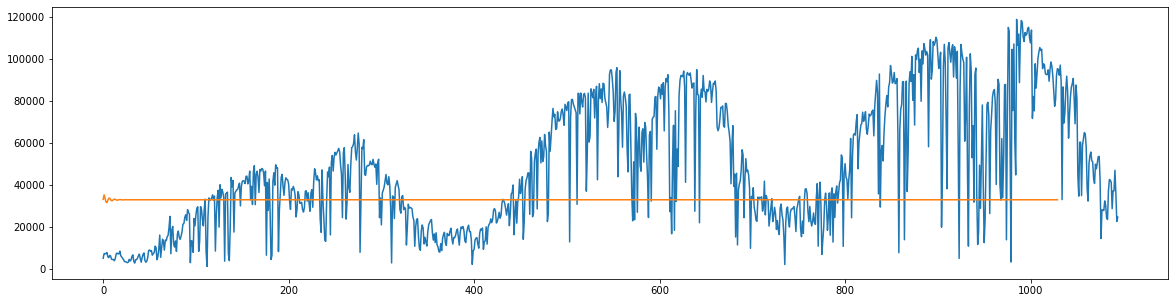

In [56]:
model = ARIMA(y, order=optimal[0][0])
model_fit = model.fit()
forecast = model_fit.forecast(steps=1030)

plt.figure(figsize=(20,5))
plt.plot(range(len(y)), y)
plt.plot(forecast)
# 제대로 예측 못함 (주황색이 예측선)

# SARIMAX: 24
- ARIMA에서 데이터의 주기성을 추가로 고려

In [57]:
p = range(0,3)
d = range(1,2)
q = range(0,6)
m = 24
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1], x[2], m) for x in list(itertools.product(p,d,q))]

aic = []
params = []

with tqdm(total = len(pdq) * len(seasonal_pdq)) as pg:
    for i in pdq:
        for j in seasonal_pdq:
            pg.update(1)
            try:
                model = SARIMAX(y, order=(i), season_order = (j))
                model_fit = model.fit()
                aic.append(round(model_fit.aic,2))
                params.append((i,j))
            except:
                continue

  0%|                                                   | 0/324 [00:00<?, ?it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
  3%|█▎                                        | 10/324 [00:00<00:03, 99.10it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
  6%|██▌                                       | 20/324 [00:00<00:03, 99.58it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11584D+01    |proj g|=  5.34683D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.347D-08   1.116D+01
  F =   11.158416451884650     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  1.10502D+01    |proj g|=  1.20149D-01

At iterate    5    f=  1.10193D+01    |proj g|=  1.44706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      7      1     0     0   5.155D-06   1.102D+01
  F =   11.019271071253609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10502D+01    |proj g|=  1.20149D-01

At iterate    5    f=  1.10193D+01    |proj g|=  1.44706D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
  9%|███▉                                      | 30/324 [00:00<00:05, 50.06it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  1.10502D+01    |proj g|=  1.20149D-01

At iterate    5    f=  1.10193D+01    |proj g|=  1.44706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      7      1     0     0   5.155D-06   1.102D+01
  F =   11.019271071253609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10502D+01    |proj g|=  1.20149D-01

At iterate    5    f=  1.10193D+01    |proj g|=  1.44706D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 11%|████▊                                     | 37/324 [00:00<00:06, 42.78it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10502D+01    |proj g|=  1.20149D-01

At iterate    5    f=  1.10193D+01    |proj g|=  1.44706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      7      1     0     0   5.155D-06   1.102D+01
  F =   11.019271071253609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 13%|█████▌                                    | 43/324 [00:00<00:07, 36.07it/s] This problem is unconstrained.



At iterate    5    f=  1.09909D+01    |proj g|=  3.95506D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   3.955D-06   1.099D+01
  F =   10.990857078136470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09960D+01    |proj g|=  5.80003D-02

At iterate    5    f=  1.09909D+01    |proj g|=  3.95506D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 15%|██████▏                                   | 48/324 [00:01<00:08, 32.67it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09960D+01    |proj g|=  5.80003D-02

At iterate    5    f=  1.09909D+01    |proj g|=  3.95506D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   3.955D-06   1.099D+01
  F =   10.990857078136470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 16%|██████▋                                   | 52/324 [00:01<00:08, 30.81it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 17%|███████▎                                  | 56/324 [00:01<00:09, 27.54it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09960D+01    |proj g|=  5.80003D-02

At iterate    5    f=  1.09909D+01    |proj g|=  3.95506D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   3.955D-06   1.099D+01
  F =   10.990857078136470     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 18%|███████▋                                  | 59/324 [00:01<00:11, 22.33it/s] This problem is unconstrained.



At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.765D-06   1.099D+01
  F =   10.989165402256733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09911D+01    |proj g|=  3.72880D-02

At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 19%|████████                                  | 62/324 [00:01<00:13, 19.09it/s]


At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.765D-06   1.099D+01
  F =   10.989165402256733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09911D+01    |proj g|=  3.72880D-02

At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 20%|████████▍                                 | 65/324 [00:02<00:15, 16.91it/s]


At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.765D-06   1.099D+01
  F =   10.989165402256733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09911D+01    |proj g|=  3.72880D-02

At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 21%|████████▋                                 | 67/324 [00:02<00:16, 15.79it/s] This problem is unconstrained.



At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.765D-06   1.099D+01
  F =   10.989165402256733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09911D+01    |proj g|=  3.72880D-02

At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 21%|████████▉                                 | 69/324 [00:02<00:16, 15.06it/s] This problem is unconstrained.
 This problem is unconstrained.
 22%|█████████▏                                | 71/324 [00:02<00:17, 14.48it/s]


At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.765D-06   1.099D+01
  F =   10.989165402256733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09911D+01    |proj g|=  3.72880D-02

At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 23%|█████████▍                                | 73/324 [00:02<00:17, 14.05it/s] This problem is unconstrained.



At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   1.765D-06   1.099D+01
  F =   10.989165402256733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09911D+01    |proj g|=  3.72880D-02

At iterate    5    f=  1.09892D+01    |proj g|=  1.86872D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 23%|█████████▋                                | 75/324 [00:03<00:18, 13.34it/s] This problem is unconstrained.
 This problem is unconstrained.
 24%|█████████▉                                | 77/324 [00:03<00:19, 12.87it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   6.637D-06   1.099D+01
  F =   10.987610441068934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.27682D-03

At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 24%|██████████▏                               | 79/324 [00:03<00:19, 12.45it/s] This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   6.637D-06   1.099D+01
  F =   10.987610441068934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.27682D-03

At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 25%|██████████▌                               | 81/324 [00:03<00:19, 12.22it/s] This problem is unconstrained.
 This problem is unconstrained.
 26%|██████████▊                               | 83/324 [00:03<00:20, 12.04it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   6.637D-06   1.099D+01
  F =   10.987610441068934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.27682D-03

At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 26%|███████████                               | 85/324 [00:03<00:20, 11.94it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   6.637D-06   1.099D+01
  F =   10.987610441068934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.27682D-03

At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 27%|███████████▎                              | 87/324 [00:04<00:19, 11.93it/s] This problem is unconstrained.
 This problem is unconstrained.
 27%|███████████▌                              | 89/324 [00:04<00:19, 11.92it/s] This problem is unconstrained.



At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   6.637D-06   1.099D+01
  F =   10.987610441068934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.27682D-03

At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 28%|███████████▊                              | 91/324 [00:04<00:19, 11.85it/s] This problem is unconstrained.



At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      9      1     0     0   6.637D-06   1.099D+01
  F =   10.987610441068934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.27682D-03

At iterate    5    f=  1.09876D+01    |proj g|=  4.99655D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 29%|████████████                              | 93/324 [00:04<00:23,  9.85it/s]

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 30%|████████████▍                             | 96/324 [00:05<00:27,  8.29it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 30%|████████████▋                             | 98/324 [00:05<00:29,  7.65it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 31%|████████████▋                            | 100/324 [00:05<00:30,  7.34it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 31%|████████████▉                            | 102/324 [00:05<00:30,  7.17it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 32%|█████████████▏                           | 104/324 [00:06<00:31,  7.09it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 32%|█████████████▎                           | 105/324 [00:06<00:31,  7.04it/s] This problem is unconstrained.


Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 33%|█████████████▌                           | 107/324 [00:06<00:31,  7.00it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 34%|█████████████▊                           | 109/324 [00:06<00:30,  6.96it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     11      1     0     0   2.061D-06   1.099D+01
  F =   10.987600246285687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09907D+01    |proj g|=  5.25228D-02

At iterate    5    f=  1.09876D+01    |proj g|=  1.51033D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 35%|██████████████▌                          | 115/324 [00:07<00:11, 18.71it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 37%|███████████████▎                         | 121/324 [00:07<00:07, 28.35it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11145D+01    |proj g|=  5.80126D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   2.311D-05   1.111D+01
  F =   11.114459269329721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 39%|████████████████                         | 127/324 [00:07<00:05, 35.92it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11145D+01    |proj g|=  5.80126D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1      3      1     0     0   2.311D-05   1.111D+01
  F =   11.114459269329721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11195D+01    |proj g|=  2.40661D-01

At iterate    5    f=  1.10621D+01    |proj g|=  7.20862D-02

At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

       

 This problem is unconstrained.
 40%|████████████████▌                        | 131/324 [00:07<00:09, 19.58it/s] This problem is unconstrained.



At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11195D+01    |proj g|=  2.40661D-01

At iterate    5    f=  1.10621D+01    |proj g|=  7.20862D-02

At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11195D+01    |proj g|=  2.40661D-01

At iterate    5    f=  1.10621D+01    |proj g|=  7.20862D-02

At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

       

 42%|█████████████████                        | 135/324 [00:08<00:12, 14.92it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11195D+01    |proj g|=  2.40661D-01

At iterate    5    f=  1.10621D+01    |proj g|=  7.20862D-02

At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 43%|█████████████████▍                       | 138/324 [00:08<00:14, 13.10it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11195D+01    |proj g|=  2.40661D-01

At iterate    5    f=  1.10621D+01    |proj g|=  7.20862D-02

At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 43%|█████████████████▋                       | 140/324 [00:08<00:15, 12.21it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11195D+01    |proj g|=  2.40661D-01

At iterate    5    f=  1.10621D+01    |proj g|=  7.20862D-02

At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 44%|█████████████████▉                       | 142/324 [00:08<00:15, 11.49it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11195D+01    |proj g|=  2.40661D-01

At iterate    5    f=  1.10621D+01    |proj g|=  7.20862D-02

At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 44%|██████████████████▏                      | 144/324 [00:09<00:16, 10.96it/s] This problem is unconstrained.
 This problem is unconstrained.
 45%|██████████████████▍                      | 146/324 [00:09<00:16, 10.98it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11195D+01    |proj g|=  2.40661D-01

At iterate    5    f=  1.10621D+01    |proj g|=  7.20862D-02

At iterate   10    f=  1.09983D+01    |proj g|=  2.28410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   4.025D-06   1.100D+01
  F =   10.998317067986186     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 46%|██████████████████▋                      | 148/324 [00:09<00:15, 11.43it/s] This problem is unconstrained.



At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iterate   10    f=  1.09897D+01    |proj g|=  1.60529D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.605D-06   1.099D+01
  F =   10.989694668212421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09928D+01    |proj g|=  4.40863D-02

At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iter

 This problem is unconstrained.
 46%|██████████████████▉                      | 150/324 [00:09<00:14, 11.81it/s] This problem is unconstrained.
 This problem is unconstrained.
 47%|███████████████████▏                     | 152/324 [00:09<00:14, 12.13it/s]


At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iterate   10    f=  1.09897D+01    |proj g|=  1.60529D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.605D-06   1.099D+01
  F =   10.989694668212421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09928D+01    |proj g|=  4.40863D-02

At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 48%|███████████████████▍                     | 154/324 [00:09<00:13, 12.36it/s] This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09928D+01    |proj g|=  4.40863D-02

At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iterate   10    f=  1.09897D+01    |proj g|=  1.60529D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.605D-06   1.099D+01
  F =   10.989694668212421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10



 This problem is unconstrained.
 48%|███████████████████▋                     | 156/324 [00:10<00:14, 11.48it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09928D+01    |proj g|=  4.40863D-02

At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iterate   10    f=  1.09897D+01    |proj g|=  1.60529D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.605D-06   1.099D+01
  F =   10.989694668212421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 49%|███████████████████▉                     | 158/324 [00:10<00:13, 11.93it/s] This problem is unconstrained.
 This problem is unconstrained.
 49%|████████████████████▏                    | 160/324 [00:10<00:13, 12.35it/s]

    4     10     12      1     0     0   1.605D-06   1.099D+01
  F =   10.989694668212421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09928D+01    |proj g|=  4.40863D-02

At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iterate   10    f=  1.09897D+01    |proj g|=  1.60529D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.605D-06   1.099D+01
  F =  

 This problem is unconstrained.
 This problem is unconstrained.
 50%|████████████████████▌                    | 162/324 [00:10<00:12, 12.61it/s] This problem is unconstrained.



At iterate   10    f=  1.09897D+01    |proj g|=  1.60529D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.605D-06   1.099D+01
  F =   10.989694668212421     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09928D+01    |proj g|=  4.40863D-02

At iterate    5    f=  1.09902D+01    |proj g|=  1.30470D-02

At iterate   10    f=  1.09897D+01    |proj g|=  1.60529D-06

       

 This problem is unconstrained.
 51%|████████████████████▊                    | 164/324 [00:10<00:14, 11.25it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 51%|█████████████████████                    | 166/324 [00:11<00:16,  9.38it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 52%|█████████████████████▎                   | 168/324 [00:11<00:18,  8.37it/s]


At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iter

 This problem is unconstrained.
 52%|█████████████████████▍                   | 169/324 [00:11<00:19,  8.03it/s] This problem is unconstrained.



At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iter

 53%|█████████████████████▋                   | 171/324 [00:11<00:20,  7.31it/s]


At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iter

 This problem is unconstrained.
 53%|█████████████████████▉                   | 173/324 [00:12<00:21,  6.99it/s]


At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iter

 This problem is unconstrained.
 54%|██████████████████████                   | 174/324 [00:12<00:21,  6.90it/s] This problem is unconstrained.



At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iter

 54%|██████████████████████▎                  | 176/324 [00:12<00:21,  6.80it/s]


At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iter

 This problem is unconstrained.
 55%|██████████████████████▌                  | 178/324 [00:12<00:22,  6.61it/s]


At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iter

 This problem is unconstrained.
 56%|██████████████████████▊                  | 180/324 [00:13<00:21,  6.70it/s]


At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09914D+01    |proj g|=  3.46728D-02

At iter

 This problem is unconstrained.
 56%|██████████████████████▉                  | 181/324 [00:13<00:21,  6.73it/s] This problem is unconstrained.



At iterate    5    f=  1.09896D+01    |proj g|=  1.44610D-03

At iterate   10    f=  1.09886D+01    |proj g|=  8.84257D-03

At iterate   15    f=  1.09883D+01    |proj g|=  1.07719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   5.814D-06   1.099D+01
  F =   10.988334359516733     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iter

 56%|███████████████████████▏                 | 183/324 [00:13<00:21,  6.54it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 57%|███████████████████████▍                 | 185/324 [00:13<00:21,  6.47it/s]


At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

       

 This problem is unconstrained.
 58%|███████████████████████▋                 | 187/324 [00:14<00:21,  6.44it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iter

 This problem is unconstrained.
 58%|███████████████████████▉                 | 189/324 [00:14<00:21,  6.40it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iter

 This problem is unconstrained.
 59%|████████████████████████▏                | 191/324 [00:14<00:20,  6.40it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iter

 This problem is unconstrained.
 60%|████████████████████████▍                | 193/324 [00:15<00:20,  6.30it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iter

 This problem is unconstrained.
 60%|████████████████████████▌                | 194/324 [00:15<00:20,  6.28it/s] This problem is unconstrained.



At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iter

 60%|████████████████████████▊                | 196/324 [00:15<00:20,  6.27it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 61%|█████████████████████████                | 198/324 [00:16<00:19,  6.30it/s]


At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  6.01177D-03

At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iter

 This problem is unconstrained.
 61%|█████████████████████████▏               | 199/324 [00:16<00:19,  6.28it/s] This problem is unconstrained.



At iterate    5    f=  1.09876D+01    |proj g|=  5.86500D-04

At iterate   10    f=  1.09876D+01    |proj g|=  4.74637D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.735D-06   1.099D+01
  F =   10.987591173441295     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iter

 62%|█████████████████████████▎               | 200/324 [00:16<00:24,  5.02it/s]


At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02


 This problem is unconstrained.
 62%|█████████████████████████▍               | 201/324 [00:16<00:27,  4.40it/s]


At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03


 This problem is unconstrained.
 62%|█████████████████████████▌               | 202/324 [00:17<00:30,  4.05it/s]


At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03


 This problem is unconstrained.
 63%|█████████████████████████▋               | 203/324 [00:17<00:31,  3.83it/s]


At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03


 This problem is unconstrained.
 63%|█████████████████████████▊               | 204/324 [00:17<00:32,  3.69it/s]


At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02


 This problem is unconstrained.
 63%|█████████████████████████▉               | 205/324 [00:17<00:33,  3.59it/s]


At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iter

 This problem is unconstrained.
 64%|██████████████████████████               | 206/324 [00:18<00:33,  3.54it/s]


At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02


 This problem is unconstrained.
 64%|██████████████████████████▏              | 207/324 [00:18<00:33,  3.51it/s]


At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02


 This problem is unconstrained.
 64%|██████████████████████████▎              | 208/324 [00:18<00:33,  3.49it/s]


At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02


 This problem is unconstrained.
 65%|██████████████████████████▍              | 209/324 [00:19<00:33,  3.48it/s]


At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iter

 This problem is unconstrained.
 65%|██████████████████████████▌              | 210/324 [00:19<00:32,  3.47it/s]

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03


 This problem is unconstrained.
 65%|██████████████████████████▋              | 211/324 [00:19<00:32,  3.47it/s]


At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03


 This problem is unconstrained.
 65%|██████████████████████████▊              | 212/324 [00:20<00:32,  3.46it/s]


At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02



 This problem is unconstrained.
 66%|██████████████████████████▉              | 213/324 [00:20<00:32,  3.44it/s]

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02



 This problem is unconstrained.
 66%|███████████████████████████              | 214/324 [00:20<00:32,  3.42it/s]

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02


 This problem is unconstrained.
 66%|███████████████████████████▏             | 215/324 [00:20<00:32,  3.33it/s]


At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02

At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02


 67%|███████████████████████████▎             | 216/324 [00:21<00:32,  3.35it/s]


At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09885D+01    |proj g|=  3.42427D-02

At iterate    5    f=  1.09869D+01    |proj g|=  1.18753D-03

At iterate   10    f=  1.09867D+01    |proj g|=  1.31118D-02


 This problem is unconstrained.
 67%|███████████████████████████▍             | 217/324 [00:21<00:31,  3.35it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 68%|███████████████████████████▉             | 221/324 [00:21<00:13,  7.84it/s]


At iterate   15    f=  1.09862D+01    |proj g|=  1.20721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   3.354D-05   1.099D+01
  F =   10.986197286825405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10546D+01    |proj g|=  3.24895D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 69%|████████████████████████████▍            | 225/324 [00:21<00:07, 12.43it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 71%|████████████████████████████▉            | 229/324 [00:21<00:05, 16.97it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   6.286D-05   1.105D+01
  F =   11.054625718006021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10546D+01    |proj g|=  3.24895D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 72%|█████████████████████████████▍           | 233/324 [00:21<00:04, 21.24it/s] This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 73%|█████████████████████████████▊           | 236/324 [00:22<00:03, 22.13it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   6.286D-05   1.105D+01
  F =   11.054625718006021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10546D+01    |proj g|=  3.24895D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 74%|██████████████████████████████▏          | 239/324 [00:22<00:04, 19.22it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09933D+01    |proj g|=  9.85840D-02

At iterate    5    f=  1.09880D+01    |proj g|=  6.67790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   5.948D-06   1.099D+01
  F =   10.987971509746162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 75%|██████████████████████████████▌          | 242/324 [00:22<00:04, 17.55it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09933D+01    |proj g|=  9.85840D-02

At iterate    5    f=  1.09880D+01    |proj g|=  6.67790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   5.948D-06   1.099D+01
  F =   10.987971509746162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 76%|███████████████████████████████          | 245/324 [00:22<00:04, 16.51it/s]


At iterate    5    f=  1.09880D+01    |proj g|=  6.67790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   5.948D-06   1.099D+01
  F =   10.987971509746162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09933D+01    |proj g|=  9.85840D-02

At iterate    5    f=  1.09880D+01    |proj g|=  6.67790D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 76%|███████████████████████████████▎         | 247/324 [00:22<00:04, 16.09it/s] This problem is unconstrained.
 This problem is unconstrained.
 77%|███████████████████████████████▌         | 249/324 [00:22<00:04, 15.67it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   5.948D-06   1.099D+01
  F =   10.987971509746162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09933D+01    |proj g|=  9.85840D-02

At iterate    5    f=  1.09880D+01    |proj g|=  6.67790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 77%|███████████████████████████████▊         | 251/324 [00:23<00:04, 15.34it/s] This problem is unconstrained.
 This problem is unconstrained.


    4      9     11      1     0     0   5.948D-06   1.099D+01
  F =   10.987971509746162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09933D+01    |proj g|=  9.85840D-02

At iterate    5    f=  1.09880D+01    |proj g|=  6.67790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   5.948D-06   1.099D+01
  F =   10.987971509746162     

CONVERGENCE: NORM_OF_PROJECTED_GRADI

 78%|████████████████████████████████         | 253/324 [00:23<00:04, 15.14it/s] This problem is unconstrained.
 This problem is unconstrained.


    4      9     11      1     0     0   5.948D-06   1.099D+01
  F =   10.987971509746162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =  

 79%|████████████████████████████████▎        | 255/324 [00:23<00:05, 12.61it/s] This problem is unconstrained.


    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =  

 This problem is unconstrained.
 79%|████████████████████████████████▌        | 257/324 [00:23<00:05, 11.18it/s] This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

       

 80%|████████████████████████████████▊        | 259/324 [00:23<00:06, 10.32it/s] This problem is unconstrained.



At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

       

 This problem is unconstrained.
 81%|█████████████████████████████████        | 261/324 [00:24<00:06,  9.79it/s] This problem is unconstrained.



At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iter

 This problem is unconstrained.
 81%|█████████████████████████████████▍       | 264/324 [00:24<00:06,  9.32it/s]


At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iter

 This problem is unconstrained.
 82%|█████████████████████████████████▋       | 266/324 [00:24<00:06,  9.08it/s]


At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

       

 This problem is unconstrained.
 83%|█████████████████████████████████▉       | 268/324 [00:24<00:06,  8.91it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 83%|██████████████████████████████████▏      | 270/324 [00:25<00:06,  8.78it/s]


At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09905D+01    |proj g|=  3.58357D-02

At iterate    5    f=  1.09877D+01    |proj g|=  3.93917D-03

At iterate   10    f=  1.09866D+01    |proj g|=  1.39155D-03

       

 This problem is unconstrained.
 84%|██████████████████████████████████▎      | 271/324 [00:25<00:06,  8.75it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   4.645D-06   1.099D+01
  F =   10.986618990936588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04


 84%|██████████████████████████████████▍      | 272/324 [00:25<00:07,  6.90it/s]


At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iter

 This problem is unconstrained.
 84%|██████████████████████████████████▌      | 273/324 [00:25<00:08,  6.00it/s]


At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02


 This problem is unconstrained.
 85%|██████████████████████████████████▋      | 274/324 [00:25<00:09,  5.48it/s]


At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04

At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iter

 This problem is unconstrained.
 85%|██████████████████████████████████▊      | 275/324 [00:26<00:09,  5.17it/s]


At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04

At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iter

 This problem is unconstrained.
 85%|██████████████████████████████████▉      | 276/324 [00:26<00:09,  4.97it/s]


At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04

At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iter

 This problem is unconstrained.
 85%|███████████████████████████████████      | 277/324 [00:26<00:09,  4.83it/s]


At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iter

 This problem is unconstrained.
 86%|███████████████████████████████████▏     | 278/324 [00:26<00:09,  4.74it/s] This problem is unconstrained.



At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03


 86%|███████████████████████████████████▎     | 279/324 [00:27<00:09,  4.68it/s]


At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04

At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03


 This problem is unconstrained.
 86%|███████████████████████████████████▍     | 280/324 [00:27<00:09,  4.63it/s]


At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04

At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 87%|███████████████████████████████████▌     | 281/324 [00:27<00:09,  4.60it/s] This problem is unconstrained.



At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04

At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 87%|███████████████████████████████████▋     | 282/324 [00:27<00:09,  4.59it/s]


At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03


 This problem is unconstrained.
 87%|███████████████████████████████████▊     | 283/324 [00:27<00:08,  4.57it/s] This problem is unconstrained.



At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04

At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03


 88%|███████████████████████████████████▉     | 284/324 [00:28<00:08,  4.56it/s] This problem is unconstrained.



At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04

At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 88%|████████████████████████████████████     | 285/324 [00:28<00:08,  4.55it/s]


At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iter

 This problem is unconstrained.
 88%|████████████████████████████████████▏    | 286/324 [00:28<00:08,  4.55it/s]


At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iter

 This problem is unconstrained.
 89%|████████████████████████████████████▎    | 287/324 [00:28<00:08,  4.55it/s]


At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iter

 This problem is unconstrained.
 89%|████████████████████████████████████▍    | 288/324 [00:29<00:07,  4.54it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09877D+01    |proj g|=  7.19493D-03

At iterate    5    f=  1.09874D+01    |proj g|=  1.06862D-02

At iterate   10    f=  1.09872D+01    |proj g|=  7.11132D-03

At iterate   15    f=  1.09864D+01    |proj g|=  4.87813D-04


 This problem is unconstrained.
 89%|████████████████████████████████████▌    | 289/324 [00:29<00:07,  4.54it/s] This problem is unconstrained.



At iterate   20    f=  1.09864D+01    |proj g|=  3.88047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   9.117D-06   1.099D+01
  F =   10.986364351500200     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02


 90%|████████████████████████████████████▋    | 290/324 [00:29<00:09,  3.54it/s]


At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 90%|████████████████████████████████████▊    | 291/324 [00:30<00:10,  3.02it/s]


At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03


 90%|████████████████████████████████████▉    | 292/324 [00:30<00:11,  2.79it/s]


At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iter

 This problem is unconstrained.
 90%|█████████████████████████████████████    | 293/324 [00:30<00:11,  2.66it/s]


At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04


 91%|█████████████████████████████████████▏   | 294/324 [00:31<00:11,  2.57it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02


 This problem is unconstrained.
 91%|█████████████████████████████████████▎   | 295/324 [00:31<00:11,  2.51it/s]


At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04


 91%|█████████████████████████████████████▍   | 296/324 [00:32<00:11,  2.47it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02


 This problem is unconstrained.
 92%|█████████████████████████████████████▌   | 297/324 [00:32<00:11,  2.45it/s]


At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 92%|█████████████████████████████████████▋   | 298/324 [00:33<00:10,  2.43it/s]


At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04


 92%|█████████████████████████████████████▊   | 299/324 [00:33<00:10,  2.42it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03


 This problem is unconstrained.
 93%|█████████████████████████████████████▉   | 300/324 [00:33<00:09,  2.41it/s]


At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iter

 This problem is unconstrained.
 93%|██████████████████████████████████████   | 301/324 [00:34<00:09,  2.41it/s]


At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02


 This problem is unconstrained.



At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04


 93%|██████████████████████████████████████▏  | 302/324 [00:34<00:09,  2.41it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02


 This problem is unconstrained.
 94%|██████████████████████████████████████▎  | 303/324 [00:35<00:08,  2.41it/s]


At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04


 94%|██████████████████████████████████████▍  | 304/324 [00:35<00:08,  2.41it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03


 This problem is unconstrained.
 94%|██████████████████████████████████████▌  | 305/324 [00:35<00:07,  2.40it/s]


At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.
 94%|██████████████████████████████████████▋  | 306/324 [00:36<00:07,  2.40it/s]


At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03

At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09874D+01    |proj g|=  1.95756D-02

At iterate    5    f=  1.09871D+01    |proj g|=  2.58472D-03

At iterate   10    f=  1.09864D+01    |proj g|=  1.66067D-02

At iterate   15    f=  1.09854D+01    |proj g|=  2.82269D-03

At iterate   20    f=  1.09850D+01    |proj g|=  2.90754D-03


 95%|██████████████████████████████████████▊  | 307/324 [00:36<00:07,  2.39it/s]


At iterate   25    f=  1.09844D+01    |proj g|=  3.44030D-03

At iterate   30    f=  1.09844D+01    |proj g|=  3.64273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     40      1     0     0   1.058D-05   1.098D+01
  F =   10.984416415338321     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02


 This problem is unconstrained.
 95%|██████████████████████████████████████▉  | 308/324 [00:37<00:06,  2.35it/s]


At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03


 95%|███████████████████████████████████████  | 309/324 [00:37<00:06,  2.32it/s]


At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03


 This problem is unconstrained.



At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04


 96%|███████████████████████████████████████▏ | 310/324 [00:38<00:06,  2.30it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03



 This problem is unconstrained.
 96%|███████████████████████████████████████▎ | 311/324 [00:38<00:05,  2.29it/s]

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03


 96%|███████████████████████████████████████▍ | 312/324 [00:39<00:05,  2.28it/s]


At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03


 This problem is unconstrained.
 97%|███████████████████████████████████████▌ | 313/324 [00:39<00:04,  2.28it/s]


At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 97%|███████████████████████████████████████▋ | 314/324 [00:39<00:04,  2.26it/s]


At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02


 This problem is unconstrained.



At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 97%|███████████████████████████████████████▊ | 315/324 [00:40<00:03,  2.26it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03


 98%|███████████████████████████████████████▉ | 316/324 [00:40<00:03,  2.26it/s]


At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02


 This problem is unconstrained.



At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03


 98%|████████████████████████████████████████ | 317/324 [00:41<00:03,  2.26it/s]


At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03


 This problem is unconstrained.



At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 98%|████████████████████████████████████████▏| 318/324 [00:41<00:02,  2.25it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02


 98%|████████████████████████████████████████▎| 319/324 [00:42<00:02,  2.25it/s]


At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02


 This problem is unconstrained.



At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 99%|████████████████████████████████████████▍| 320/324 [00:42<00:01,  2.25it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03


 99%|████████████████████████████████████████▌| 321/324 [00:43<00:01,  2.26it/s]


At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02


 This problem is unconstrained.



At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04


 99%|████████████████████████████████████████▋| 322/324 [00:43<00:00,  2.26it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03


 This problem is unconstrained.
100%|████████████████████████████████████████▊| 323/324 [00:43<00:00,  2.26it/s]


At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04


100%|█████████████████████████████████████████| 324/324 [00:44<00:00,  2.26it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09890D+01    |proj g|=  5.52115D-02



 This problem is unconstrained.
100%|█████████████████████████████████████████| 324/324 [00:44<00:00,  7.23it/s]

At iterate    5    f=  1.09867D+01    |proj g|=  7.52135D-03

At iterate   10    f=  1.09854D+01    |proj g|=  1.82359D-02

At iterate   15    f=  1.09846D+01    |proj g|=  1.07940D-03

At iterate   20    f=  1.09844D+01    |proj g|=  3.85076D-03

At iterate   25    f=  1.09843D+01    |proj g|=  3.76625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     31      1     0     0   1.696D-05   1.098D+01
  F =   10.984292429129454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [58]:
optimal = [(params[i],j) for i,j in enumerate(aic) if j == min(aic)]
model_opt = SARIMAX(y, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10835D+01    |proj g|=  1.46333D-02


 This problem is unconstrained.



At iterate    5    f=  1.10829D+01    |proj g|=  1.16344D-03

At iterate   10    f=  1.10826D+01    |proj g|=  1.85945D-02

At iterate   15    f=  1.10818D+01    |proj g|=  3.61691D-03

At iterate   20    f=  1.10816D+01    |proj g|=  2.34763D-03

At iterate   25    f=  1.10797D+01    |proj g|=  2.83297D-02

At iterate   30    f=  1.10774D+01    |proj g|=  3.26964D-02

At iterate   35    f=  1.10725D+01    |proj g|=  9.29286D-02

At iterate   40    f=  1.10677D+01    |proj g|=  2.28559D-02

At iterate   45    f=  1.10647D+01    |proj g|=  9.27237D-02

At iterate   50    f=  1.10629D+01    |proj g|=  2.73432D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/goguma/miniforge3/envs/torch-cpu/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1095
Model:             SARIMAX(2, 1, 4)x(0, 1, [], 24)   Log Likelihood              -12113.926
Date:                             Tue, 28 Jun 2022   AIC                          24241.852
Time:                                     20:40:00   BIC                          24276.680
Sample:                                          0   HQIC                         24255.045
                                            - 1095                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3112      0.018     74.602      0.000       1.277       1.346
ar.L2         -0.9099      0.017    -53.495      0.000      -0.943      -0.877
ma.L1         -1.9753      0.030    -66.639      0.000      -2.033      -1.917
ma.L2          1.5560      0.063     24.612      0.000       1.432       1.680
ma.L3         -0.2407      0.060     -4.019      0.000      -0.358      -0.123
ma.L4         -0.2354      0.026     -9.212      0.000      -0.285      -0.185
sigma2      4.274e+08   1.05e-11   4.07e+19      0.000    4.27e+08    4.27e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               446.17
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               4.57   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.43e+35. Standard errors may be unstable.
"""

/Users/goguma/miniforge3/envs/torch-cpu/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


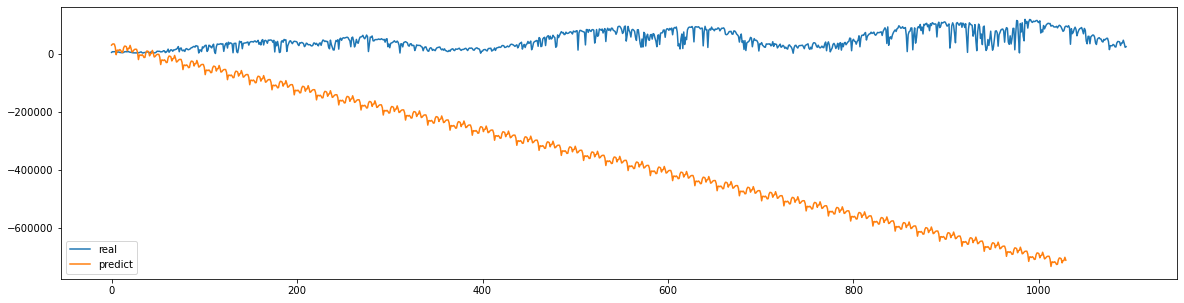

In [59]:
model = SARIMAX(y, order=optimal[0][0][0], seasonal_order=optimal[0][0][1])
model_fit = model.fit(disp=0)
forecast = model_fit.forecast(steps=1030)

plt.figure(figsize=(20,5))
plt.plot(range(len(y)), y, label="real")
plt.plot(forecast, label="predict")
plt.legend()
plt.show()

In [154]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(X_year, order=(0,1,1))
model_fit = model.fit(trend='c',full_output=True, disp=1)
print(model_fit.summary())

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


# Deep Learning

In [112]:
import torch
import torch.nn as nn
import torch.nn.init as weight_init
from torch.optim import Adam
from torchinfo import summary
from tqdm import trange

In [132]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(14, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 1)
        self.act_fuc = nn.Sigmoid()
        
    def forward(self, x):
        y = self.fc1(x)
        y = self.act_fuc(y)
        y = self.fc2(y)
        y = self.act_fuc(y)
        y = self.fc3(y)
        return y

In [ ]:
loss_fuc = nn.MSELoss()
epochs = 2000
lr = 1e-2

model = LinearModel()

# 모델 summary
print(summary(model, input_size=(1,14)))


# # 정규분포로 파라미터 초기화
# dict = {}
# for name, param in model.named_parameters():
#     weight_init.normal(param)
#     dict[name] = param
        
optimizer = Adam(model.parameters(), lr=lr)


mean_loss = []
print("=====train=====")
for epoch in trange(epochs):
    loss_history = []
    tensor_x = torch.tensor(X_year, dtype=torch.float32)
    tensor_y = torch.tensor(y, dtype=torch.float32)
    
    for x, tgt in zip(tensor_x, tensor_y):
        model.train()
        
        pred = model(x)
        
#         print(pred.shape)
#         print(tgt.shape)
        loss = loss_fuc(pred, tgt.unsqueeze(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())
    mean_loss.append(np.mean(loss_history))
    

In [155]:
model = LinearModel()
t = torch.tensor(X_year, dtype=torch.float32)
pred = model(t[0])
t2 = torch.tensor(y, dtype=torch.float32)
t2[0] - pred

t2[0].unsqueeze(0).shape

torch.Size([1])

In [101]:
t.squeeze(0)

tensor([0.5969, 0.5400, 0.1720, 0.8251, 0.7227, 0.2781, 0.8674, 0.7925, 0.2939,
        0.5828, 0.1199, 0.7834, 0.8683, 0.9781])

In [105]:
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])
